In [33]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

In [34]:
df = pd.read_csv('training_set.csv')
df

,label,cleaned_article,num_punctuations,no_of_stopwords,no_of_quesMarks,no_of_exclamation,no_of_sentence,sentiment,cc_cd,determiner,...,noun,adverb,verb,article_len,negations,polarity,word_count,avg_word_len,num_unique_words,num_chars
0,1,seeking best woman final return fridaysunday y...,139,634,5,0,41,Positive,37,98,...,236,27,150,4563,6,0.049887,357,6.392157,234,2638
1,0,harsh reality come taking responsibility life ...,112,702,2,3,37,Positive,53,79,...,196,85,230,5470,15,0.029320,347,6.573487,263,2627
2,0,finally obama speaks american need reconcile t...,65,415,1,0,21,Positive,17,67,...,145,28,116,3324,2,0.222891,244,6.950820,172,1939
3,1,house plan increase trump disaster request was...,46,221,0,0,9,Negative,19,19,...,87,5,33,1514,0,-0.062500,127,7.385827,97,1064
4,1,leftist cusp power weary icelander poll reykja...,89,523,0,0,26,Positive,35,67,...,193,16,120,3851,0,0.134749,313,6.872204,230,2463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96512,1,german prosecutor accuse farright party leader...,33,217,0,0,12,Positive,9,43,...,88,9,51,1794,0,0.023260,140,6.657143,97,1071
96513,0,facebook posting switzerland government issue ...,8,16,0,3,5,Negative,0,7,...,11,1,3,159,0,0.200000,13,7.153846,13,105
96514,1,president trump immediate investigation chuck ...,43,244,0,2,15,Negative,17,24,...,105,3,37,1706,1,0.028571,145,6.951724,85,1152
96515,0,zapatistas solidarizamse resistncia yaqui zapa...,51,440,0,0,9,Negative,8,21,...,234,2,66,2661,3,0.033333,267,6.981273,179,2130


<AxesSubplot:xlabel='word_count', ylabel='Count'>

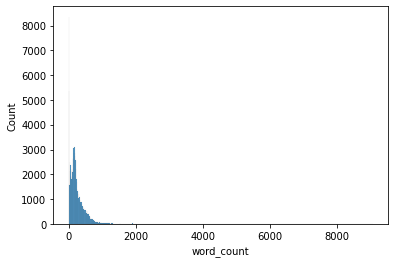

In [35]:
sn.histplot(df['word_count'])

In [36]:
#df = df[(df['word_count']>10) & (df['word_count']<8000)]

In [37]:
# Sentiment is a categorical data, we have to encode it for model training
from sklearn.preprocessing import OneHotEncoder
def Encoding_sentiment(df):
    encoder = OneHotEncoder(drop = 'first') # Creating object of OneHotEncoder class
    encoded_sentiment = encoder.fit_transform(pd.DataFrame(df['sentiment'])).toarray().astype(int) # Fitting to the data
    column_names = encoder.get_feature_names() # Getting feature name
    encoded_sentiment = pd.DataFrame(encoded_sentiment, columns = column_names)  # Creating dataframe of encoded feature
    encoded_sentiment.reset_index(drop=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, encoded_sentiment], axis = 1) # Concatinating newly created sentiment dataframe into original dataframe
    #print(df.isna().sum())
    df.drop('sentiment', axis = 1, inplace = True) # dropping sentiment column as I have already encoded this categorical feature
    return df

In [38]:
df = Encoding_sentiment(df) # Calling the function to encode Sentiment column which is a categorial feature

In [39]:
#num_fea = df.drop(['cleaned_article', 'label'], axis = 1).values # Training features
#y = df['label'].values # Target variable

## Test 1

In [40]:
# Importing testing dataset 1
test_df1 = pd.read_csv('Test/test1.csv') 
test_df1 = Encoding_sentiment(test_df1) # Encoding categorical features
test_df1.drop(index = list(test_df1[test_df1['word_count']==0].index),inplace = True, axis = 0) # dropping all those rows which have word count zero in other words rows which have empty article
test1_num = test_df1.drop(['cleaned_article','label'], axis = 1).values # Testing features
label_y1 = test_df1['label'].values # Testing labels
#test1_num = sc.transform(test1_num) # scaling features

## Test 2

In [41]:
# Importing testing dataset 2
test_df2 = pd.read_csv('Test/test2.csv')
test_df2 = Encoding_sentiment(test_df2)
test_df2.drop(index = list(test_df2[test_df2['word_count']==0].index),inplace = True, axis = 0)
test2_num = test_df2.drop(['cleaned_article','label'], axis = 1).values
test_df2.dropna(inplace = True)
label_y2 = test_df2['label'].values
#test2_num = sc.transform(test2_num)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis = 1),df['label'], test_size = 0.2)

In [43]:
#Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

#Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(X_train['cleaned_article']) 
tfidf_test=tfidf_vectorizer.transform(X_test['cleaned_article'])

In [44]:
test1_vec = tfidf_vectorizer.transform(test_df1['cleaned_article'])
test2_vec = tfidf_vectorizer.transform(test_df2['cleaned_article'])

In [45]:
tfidf_test

<19304x271500 sparse matrix of type '<class 'numpy.float64'>'
	with 3045088 stored elements in Compressed Sparse Row format>

# Models

## Logistic Regression

<AxesSubplot:>

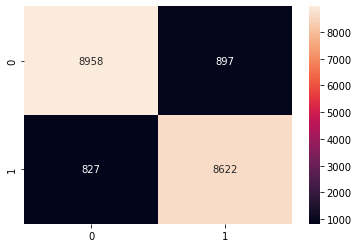

In [46]:
log_cls = LogisticRegression(penalty='l2', max_iter=250, solver = 'saga') # creating class object
log_cls.fit(tfidf_train, y_train) # fitting to the training set

log_ypred = log_cls.predict(tfidf_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, log_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [47]:
# Classification report of test set
print(classification_report(y_test, log_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.9155    0.9090    0.9122      9855
           1     0.9058    0.9125    0.9091      9449

    accuracy                         0.9107     19304
   macro avg     0.9106    0.9107    0.9107     19304
weighted avg     0.9107    0.9107    0.9107     19304



In [48]:
# Predicting on first test dataset
test1_log_ypred = log_cls.predict(test1_vec)
print(classification_report(label_y1, test1_log_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6776    0.6107    0.6424      2846
           1     0.5768    0.6461    0.6095      2337

    accuracy                         0.6267      5183
   macro avg     0.6272    0.6284    0.6259      5183
weighted avg     0.6321    0.6267    0.6276      5183



In [49]:
# Predicting on 2nd test dataset
test2_log_pred = log_cls.predict(test2_vec)
print(classification_report(label_y2, test2_log_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7069    0.9460    0.8091      3164
           1     0.9186    0.6086    0.7322      3171

    accuracy                         0.7771      6335
   macro avg     0.8128    0.7773    0.7707      6335
weighted avg     0.8129    0.7771    0.7706      6335



### Similarly I will train and test model using other algorithms as did using Logistic Regression

## KNN

<AxesSubplot:>

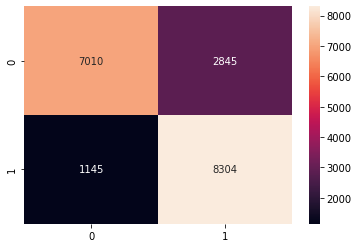

In [50]:
knn_cls = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_cls.fit(tfidf_train, y_train)
knn_ypred = knn_cls.predict(tfidf_test)

cm = confusion_matrix(y_test, knn_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [51]:
# Classification report on test set
print(classification_report(y_test, knn_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.8596    0.7113    0.7785      9855
           1     0.7448    0.8788    0.8063      9449

    accuracy                         0.7933     19304
   macro avg     0.8022    0.7951    0.7924     19304
weighted avg     0.8034    0.7933    0.7921     19304



In [52]:
# classification report on 1st test Dataset
test1_knn_ypred = knn_cls.predict(test1_vec)
print(classification_report(label_y1, test1_knn_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6474    0.5502    0.5949      2846
           1     0.5369    0.6350    0.5818      2337

    accuracy                         0.5885      5183
   macro avg     0.5921    0.5926    0.5884      5183
weighted avg     0.5976    0.5885    0.5890      5183



In [53]:
# classification report on 2nd test Dataset
test2_knn_ypred = knn_cls.predict(test2_vec)
print(classification_report(label_y2, test2_knn_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7675    0.8597    0.8110      3164
           1     0.8409    0.7401    0.7873      3171

    accuracy                         0.7998      6335
   macro avg     0.8042    0.7999    0.7991      6335
weighted avg     0.8042    0.7998    0.7991      6335



## Linear SVC

<AxesSubplot:>

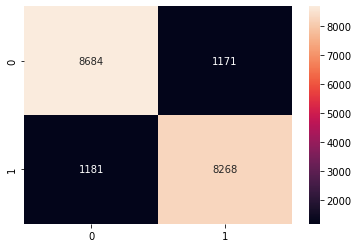

In [54]:
# Model Training
svc_clf = LinearSVC(max_iter = 2500, loss = 'squared_hinge', C = 0.01)
svc_clf.fit(tfidf_train, y_train)
svc_ypred = svc_clf.predict(tfidf_test)

cm = confusion_matrix(y_test, svc_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [55]:
# Classification report of test set
print(classification_report(y_test, svc_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.8803    0.8812    0.8807      9855
           1     0.8759    0.8750    0.8755      9449

    accuracy                         0.8782     19304
   macro avg     0.8781    0.8781    0.8781     19304
weighted avg     0.8782    0.8782    0.8782     19304



In [56]:
# Prediction on 1st Test Dataset
test1_svc_ypred = svc_clf.predict(test1_vec)
print(classification_report(label_y1, test1_svc_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6764    0.6177    0.6457      2846
           1     0.5789    0.6401    0.6080      2337

    accuracy                         0.6278      5183
   macro avg     0.6277    0.6289    0.6269      5183
weighted avg     0.6325    0.6278    0.6287      5183



In [57]:
# Prediction on 2nd Test Dataset
test2_svc_ypred = svc_clf.predict(test2_vec)
print(classification_report(label_y2, test2_svc_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7023    0.8954    0.7872      3164
           1     0.8561    0.6213    0.7200      3171

    accuracy                         0.7582      6335
   macro avg     0.7792    0.7583    0.7536      6335
weighted avg     0.7793    0.7582    0.7536      6335



## Passive Aggressive

<AxesSubplot:>

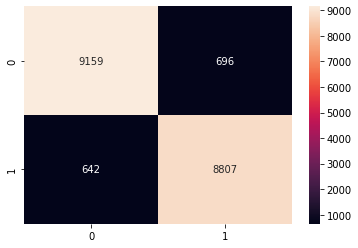

In [62]:
#Initialize a PassiveAggressiveClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=1500, C = 0.1, n_jobs=-1)
pac.fit(tfidf_train,y_train)

#Predict on the test set and calculate accuracy
pac_ypred = pac.predict(tfidf_test)

cm = confusion_matrix(y_test, pac_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [63]:
# Classification report of test set
print(classification_report(y_test, pac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.9345    0.9294    0.9319      9855
           1     0.9268    0.9321    0.9294      9449

    accuracy                         0.9307     19304
   macro avg     0.9306    0.9307    0.9307     19304
weighted avg     0.9307    0.9307    0.9307     19304



In [64]:
# Prediction on 1st Test Dataset
test1_pac_ypred = pac.predict(test1_vec)
print(classification_report(label_y1, test1_pac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6634    0.5991    0.6296      2846
           1     0.5633    0.6299    0.5947      2337

    accuracy                         0.6130      5183
   macro avg     0.6134    0.6145    0.6122      5183
weighted avg     0.6183    0.6130    0.6139      5183



In [65]:
# # Prediction on 2nd Test Dataset

test2_pac_ypred = pac.predict(test2_vec)
print(classification_report(label_y2, test2_pac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7024    0.9741    0.8162      3164
           1     0.9579    0.5881    0.7288      3171

    accuracy                         0.7809      6335
   macro avg     0.8301    0.7811    0.7725      6335
weighted avg     0.8303    0.7809    0.7725      6335



# Random Forest

<AxesSubplot:>

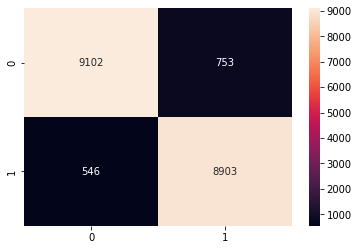

In [58]:
# Training Random Forest classifier on training set

rand_forest_cls = RandomForestClassifier(n_estimators = 270, n_jobs = -1)
rand_forest_cls.fit(tfidf_train, y_train)
randForest_ypred = rand_forest_cls.predict(tfidf_test)

cm = confusion_matrix(y_test, randForest_ypred)
sn.heatmap(cm, annot=True, fmt="d")


In [59]:
## Prediction on Test set
print(classification_report(y_test, randForest_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.9434    0.9236    0.9334      9855
           1     0.9220    0.9422    0.9320      9449

    accuracy                         0.9327     19304
   macro avg     0.9327    0.9329    0.9327     19304
weighted avg     0.9329    0.9327    0.9327     19304



In [60]:
# Prediction on 1st Test Dataset
test1_rand_ypred = rand_forest_cls.predict(test1_vec)
print(classification_report(label_y1, test1_rand_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7187    0.6086    0.6591      2846
           1     0.5983    0.7099    0.6493      2337

    accuracy                         0.6543      5183
   macro avg     0.6585    0.6592    0.6542      5183
weighted avg     0.6644    0.6543    0.6547      5183



In [61]:
# Prediction on 2nd Test Dataset
test2_rand_ypred = rand_forest_cls.predict(test2_vec)
print(classification_report(label_y2, test2_rand_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7480    0.9643    0.8425      3164
           1     0.9499    0.6758    0.7898      3171

    accuracy                         0.8199      6335
   macro avg     0.8489    0.8200    0.8161      6335
weighted avg     0.8491    0.8199    0.8161      6335



## Gradient Boosting Classifier

<AxesSubplot:>

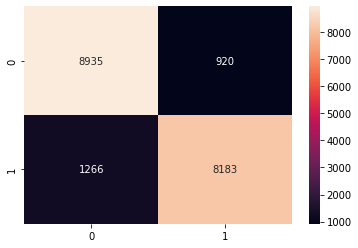

In [66]:
# Fitting model on training set of data

gb_clf = GradientBoostingClassifier(n_estimators=170)
gb_clf.fit(tfidf_train, y_train)
gb_ypred = gb_clf.predict(tfidf_test)

cm = confusion_matrix(y_test, gb_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [67]:
# Classification report of test set

print(classification_report(y_test, gb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.8759    0.9066    0.8910      9855
           1     0.8989    0.8660    0.8822      9449

    accuracy                         0.8868     19304
   macro avg     0.8874    0.8863    0.8866     19304
weighted avg     0.8872    0.8868    0.8867     19304



In [68]:
# # Prediction on 1st Test Dataset

test1_gb_ypred = gb_clf.predict(test1_vec)
print(classification_report(label_y1, test1_gb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6891    0.5840    0.6322      2846
           1     0.5727    0.6791    0.6214      2337

    accuracy                         0.6269      5183
   macro avg     0.6309    0.6315    0.6268      5183
weighted avg     0.6366    0.6269    0.6273      5183



In [69]:
# Prediction on 2nd Test Dataset

test2_gb_ypred = gb_clf.predict(test2_vec)
print(classification_report(label_y2, test2_gb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6620    0.9150    0.7682      3164
           1     0.8629    0.5339    0.6597      3171

    accuracy                         0.7242      6335
   macro avg     0.7625    0.7244    0.7139      6335
weighted avg     0.7626    0.7242    0.7139      6335



## XGBoost

[12:42:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

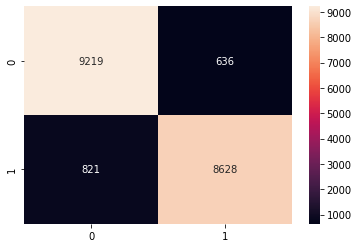

In [70]:
# Fitting model on training set of data

xgb = XGBClassifier(n_jobs = -1)

xgb.fit(tfidf_train, y_train)
xgb_ypred = xgb.predict(tfidf_test)

cm = confusion_matrix(y_test, xgb_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [71]:
# Classification report of test set
print(classification_report(y_test, xgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.9182    0.9355    0.9268      9855
           1     0.9313    0.9131    0.9221      9449

    accuracy                         0.9245     19304
   macro avg     0.9248    0.9243    0.9245     19304
weighted avg     0.9246    0.9245    0.9245     19304



In [72]:
# # Prediction on 1st Test Dataset
test1_xgb_ypred = xgb.predict(test1_vec)
print(classification_report(label_y1, test1_xgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6909    0.6086    0.6471      2846
           1     0.5837    0.6684    0.6232      2337

    accuracy                         0.6355      5183
   macro avg     0.6373    0.6385    0.6351      5183
weighted avg     0.6425    0.6355    0.6363      5183



In [73]:
# Prediction on 2nd Test Dataset

test2_xgb_ypred = xgb.predict(test2_vec)
print(classification_report(label_y2, test2_xgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6720    0.9712    0.7944      3164
           1     0.9484    0.5270    0.6775      3171

    accuracy                         0.7489      6335
   macro avg     0.8102    0.7491    0.7359      6335
weighted avg     0.8103    0.7489    0.7359      6335



# Results of TFIDF features

In [74]:
from sklearn.metrics import accuracy_score
train_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Passive Aggressive', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(y_test, log_ypred), 
               accuracy_score(y_test, knn_ypred),
               accuracy_score(y_test, svc_ypred),
               accuracy_score(y_test, randForest_ypred),
               accuracy_score(y_test, pac_ypred),
               accuracy_score(y_test, gb_ypred),
              accuracy_score(y_test, xgb_ypred)]
})

print("Prediction results of test set:")
train_result

Prediction results of test set:


,Model,Score
0,Logistic Regression,0.910692
1,KNN,0.793307
2,Linear SVM,0.878160
3,Random Forest,0.932708
4,Passive Aggressive,0.930688
5,Gradient Boosting,0.886759
6,XGBoost Classifier,0.924523


> We can see Random Forest has highest accuracy of 93.27% followed by Passive Aggressive and XGBoost on test set created during train-test split

In [76]:
test1_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Passive Aggressive', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(label_y1, test1_log_ypred),
               accuracy_score(label_y1, test1_knn_ypred),
               accuracy_score(label_y1, test1_svc_ypred),
              accuracy_score(label_y1, test1_rand_ypred),
               accuracy_score(label_y1, test1_pac_ypred),
               accuracy_score(label_y1, test1_gb_ypred),
               accuracy_score(label_y1, test1_xgb_ypred)
              ]

})

print("Predictions on 1st Test Dataset: ")
test1_result

Predictions on 1st Test Dataset: 


,Model,Score
0,Logistic Regression,0.626664
1,KNN,0.588462
2,Linear SVM,0.627822
3,Random Forest,0.654254
4,Passive Aggressive,0.612965
5,Gradient Boosting,0.626857
6,XGBoost Classifier,0.635539


> On the first dataset which is different than our training dataset we can see Random Forest is giving highest accuracy compared to any other algorithms

In [77]:
test2_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Passive Aggressive', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(label_y2, test2_log_pred),
               accuracy_score(label_y2, test2_knn_ypred),
              accuracy_score(label_y2, test2_svc_ypred),
              accuracy_score(label_y2, test2_rand_ypred),
               accuracy_score(label_y2, test2_pac_ypred),
               accuracy_score(label_y2, test2_gb_ypred),
               accuracy_score(label_y2, test2_xgb_ypred)
               
              ]

})

print("Predictions on 2nd Test Dataset: ")
test2_result

Predictions on 2nd Test Dataset: 


,Model,Score
0,Logistic Regression,0.777111
1,KNN,0.799842
2,Linear SVM,0.758169
3,Random Forest,0.819890
4,Passive Aggressive,0.780900
5,Gradient Boosting,0.724230
6,XGBoost Classifier,0.748856


> On the second dataset which is somewhat similar to our training dataset we can see Random Forest is giving highest accuracy compared to any other algorithms followed by KNN and Passive Aggressive

# TF-IDF + Numerical Feaures

In [78]:
num_feature_xtrain = X_train.drop(['cleaned_article'], axis = 1).values # Numerical features of training set
num_feature_xtest = X_test.drop(['cleaned_article'], axis = 1).values # Numerical features of testing set

In [79]:
# Scaling the data using Standard Scaler with mean = 0 and variance = 1

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(num_feature_xtrain)
num_feature_xtrain = sc.transform(num_feature_xtrain) # Scaling training set

In [80]:
num_feature_xtest = sc.transform(num_feature_xtest) # Scaling test set
test1_num = sc.transform(test1_num) # Scaling 1st test dataset
test2_num = sc.transform(test2_num) # Scaling 2nd test dataset

In [81]:
# Scacking numerical features and tfidf values and storing for further modeling

from scipy.sparse import coo_matrix, hstack
tf_num_train = hstack([tfidf_train, num_feature_xtrain])
tf_num_test = hstack([tfidf_test, num_feature_xtest])

test1_tf_num = hstack([test1_vec, test1_num])
test2_tf_num = hstack([test2_vec, test2_num])


## Logistic Regression

<AxesSubplot:>

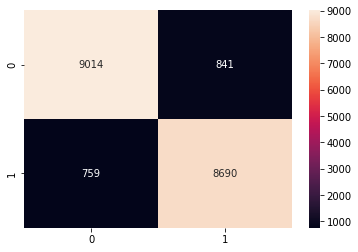

In [82]:
log_tfnum_cls = LogisticRegression(penalty='l2', max_iter=500, solver = 'liblinear') # creating class object
log_tfnum_cls.fit(tf_num_train, y_train) # fitting to the training set

log_tfnum_ypred = log_tfnum_cls.predict(tf_num_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, log_tfnum_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [83]:
# Classification report on test set
print(classification_report(y_test, log_tfnum_ypred, digits=4))

              precision    recall  f1-score   support

           0     0.9223    0.9147    0.9185      9855
           1     0.9118    0.9197    0.9157      9449

    accuracy                         0.9171     19304
   macro avg     0.9170    0.9172    0.9171     19304
weighted avg     0.9172    0.9171    0.9171     19304



In [84]:
# Predicting on first test dataset
test1_tflog_ypred = log_tfnum_cls.predict(test1_tf_num)
print(classification_report(label_y1, test1_tflog_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6820    0.6051    0.6412      2846
           1     0.5771    0.6564    0.6142      2337

    accuracy                         0.6282      5183
   macro avg     0.6296    0.6307    0.6277      5183
weighted avg     0.6347    0.6282    0.6290      5183



In [85]:
# Predicting on 2nd test dataset
test2_tflog_ypred = log_tfnum_cls.predict(test2_tf_num)
print(classification_report(label_y2, test2_tflog_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7138    0.9403    0.8115      3164
           1     0.9128    0.6238    0.7411      3171

    accuracy                         0.7818      6335
   macro avg     0.8133    0.7820    0.7763      6335
weighted avg     0.8134    0.7818    0.7763      6335



## KNN

<AxesSubplot:>

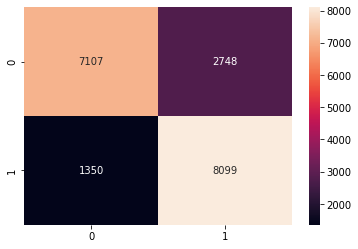

In [86]:
knn_tfnum_cls = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
knn_tfnum_cls.fit(tf_num_train, y_train) # fitting to the training set

knn_tfnum_ypred = knn_tfnum_cls.predict(tf_num_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, knn_tfnum_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [87]:
# Classification report of test set
print(classification_report(y_test, knn_tfnum_ypred, digits=4))

              precision    recall  f1-score   support

           0     0.8404    0.7212    0.7762      9855
           1     0.7467    0.8571    0.7981      9449

    accuracy                         0.7877     19304
   macro avg     0.7935    0.7891    0.7872     19304
weighted avg     0.7945    0.7877    0.7869     19304



In [88]:
# Predicting on first test dataset
test1_tfknn_ypred = knn_tfnum_cls.predict(test1_tf_num)
print(classification_report(label_y1, test1_tfknn_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7140    0.5369    0.6129      2846
           1     0.5669    0.7381    0.6413      2337

    accuracy                         0.6276      5183
   macro avg     0.6404    0.6375    0.6271      5183
weighted avg     0.6477    0.6276    0.6257      5183



In [89]:
# Predicting on 2nd test dataset
test2_tfknn_ypred = knn_tfnum_cls.predict(test2_tf_num)
print(classification_report(label_y2, test2_tfknn_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7001    0.7298    0.7146      3164
           1     0.7185    0.6881    0.7030      3171

    accuracy                         0.7089      6335
   macro avg     0.7093    0.7089    0.7088      6335
weighted avg     0.7093    0.7089    0.7088      6335



## Linear SVC

<AxesSubplot:>

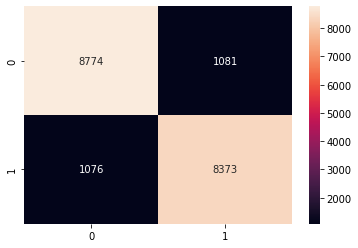

In [90]:
svc_tfnum_cls = LinearSVC(max_iter = 2500, loss = 'squared_hinge', C = 0.01) # creating class object
svc_tfnum_cls.fit(tf_num_train, y_train) # fitting to the training set

svc_tfnum_ypred = svc_tfnum_cls.predict(tf_num_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, svc_tfnum_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [91]:
# Classification report of test set
print(classification_report(y_test, svc_tfnum_ypred, digits=4))

              precision    recall  f1-score   support

           0     0.8908    0.8903    0.8905      9855
           1     0.8857    0.8861    0.8859      9449

    accuracy                         0.8883     19304
   macro avg     0.8882    0.8882    0.8882     19304
weighted avg     0.8883    0.8883    0.8883     19304



In [92]:
# Predicting on first test dataset
test1_tfsvc_ypred = svc_tfnum_cls.predict(test1_tf_num)
print(classification_report(label_y1, test1_tfsvc_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6852    0.5966    0.6379      2846
           1     0.5756    0.6662    0.6176      2337

    accuracy                         0.6280      5183
   macro avg     0.6304    0.6314    0.6277      5183
weighted avg     0.6358    0.6280    0.6287      5183



In [93]:
# Predicting on 2nd test dataset
test2_tfsvc_ypred = svc_tfnum_cls.predict(test2_tf_num)
print(classification_report(label_y2, test2_tfsvc_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6926    0.8815    0.7757      3164
           1     0.8375    0.6096    0.7056      3171

    accuracy                         0.7454      6335
   macro avg     0.7650    0.7455    0.7406      6335
weighted avg     0.7651    0.7454    0.7406      6335



## Passive Aggressive

<AxesSubplot:>

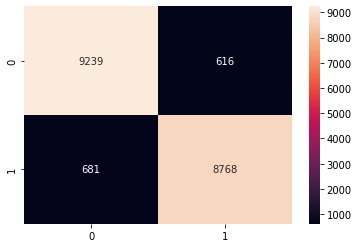

In [94]:
pac_tfnum_cls = PassiveAggressiveClassifier(max_iter=2500, C = 0.1, n_jobs=-1) # creating class object
pac_tfnum_cls.fit(tf_num_train, y_train) # fitting to the training set

pac_tfnum_ypred = pac_tfnum_cls.predict(tf_num_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, pac_tfnum_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [95]:
# Classification report of test set
print(classification_report(y_test, pac_tfnum_ypred, digits=4))

              precision    recall  f1-score   support

           0     0.9314    0.9375    0.9344      9855
           1     0.9344    0.9279    0.9311      9449

    accuracy                         0.9328     19304
   macro avg     0.9329    0.9327    0.9328     19304
weighted avg     0.9328    0.9328    0.9328     19304



In [96]:
# Predicting on first test dataset
test1_tfpac_ypred = pac_tfnum_cls.predict(test1_tf_num)
print(classification_report(label_y1, test1_tfpac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6730    0.5952    0.6317      2846
           1     0.5679    0.6478    0.6052      2337

    accuracy                         0.6189      5183
   macro avg     0.6205    0.6215    0.6185      5183
weighted avg     0.6256    0.6189    0.6198      5183



In [97]:
# Predicting on 2nd test dataset
test2_tfpac_ypred = pac_tfnum_cls.predict(test2_tf_num)
print(classification_report(label_y2, test2_tfpac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7260    0.9722    0.8312      3164
           1     0.9581    0.6339    0.7630      3171

    accuracy                         0.8028      6335
   macro avg     0.8420    0.8030    0.7971      6335
weighted avg     0.8421    0.8028    0.7971      6335



## Random Forest

<AxesSubplot:>

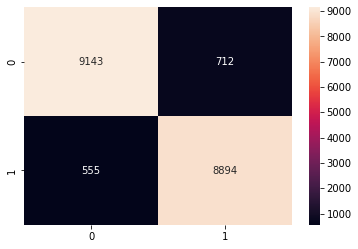

In [98]:
rand_tfnum_cls = RandomForestClassifier(n_estimators= 230, n_jobs = -1) # creating class object
rand_tfnum_cls.fit(tf_num_train, y_train) # fitting to the training set

rand_tfnum_ypred = rand_tfnum_cls.predict(tf_num_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, rand_tfnum_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [99]:
# Classification report of test set
print(classification_report(y_test, rand_tfnum_ypred, digits=4))

              precision    recall  f1-score   support

           0     0.9428    0.9278    0.9352      9855
           1     0.9259    0.9413    0.9335      9449

    accuracy                         0.9344     19304
   macro avg     0.9343    0.9345    0.9344     19304
weighted avg     0.9345    0.9344    0.9344     19304



In [100]:
# Predicting on first test dataset
test1_tfrand_ypred = rand_tfnum_cls.predict(test1_tf_num)
print(classification_report(label_y1, test1_tfrand_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7335    0.6170    0.6702      2846
           1     0.6092    0.7270    0.6629      2337

    accuracy                         0.6666      5183
   macro avg     0.6713    0.6720    0.6666      5183
weighted avg     0.6774    0.6666    0.6669      5183



In [101]:
# Predicting on 2nd test dataset
test2_tfrand_ypred = rand_tfnum_cls.predict(test2_tf_num)
print(classification_report(label_y2, test2_tfrand_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7545    0.9627    0.8460      3164
           1     0.9487    0.6875    0.7972      3171

    accuracy                         0.8249      6335
   macro avg     0.8516    0.8251    0.8216      6335
weighted avg     0.8517    0.8249    0.8216      6335



## Gradient Boosting Classifier

<AxesSubplot:>

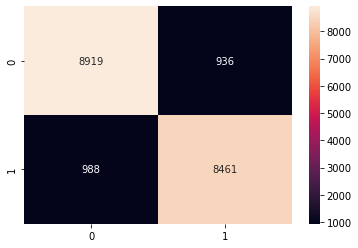

In [102]:
gb_tfnum_cls = GradientBoostingClassifier(n_estimators=190, learning_rate=0.1) # creating class object
gb_tfnum_cls.fit(tf_num_train, y_train) # fitting to the training set

gb_tfnum_ypred = gb_tfnum_cls.predict(tf_num_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, gb_tfnum_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [103]:
# Classification report of test set
print(classification_report(y_test, gb_tfnum_ypred, digits=4))

              precision    recall  f1-score   support

           0     0.9003    0.9050    0.9026      9855
           1     0.9004    0.8954    0.8979      9449

    accuracy                         0.9003     19304
   macro avg     0.9003    0.9002    0.9003     19304
weighted avg     0.9003    0.9003    0.9003     19304



In [104]:
# Predicting on first test dataset
test1_tfgb_ypred = gb_tfnum_cls.predict(test1_tf_num)
print(classification_report(label_y1, test1_tfgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6931    0.5857    0.6349      2846
           1     0.5756    0.6842    0.6252      2337

    accuracy                         0.6301      5183
   macro avg     0.6344    0.6350    0.6301      5183
weighted avg     0.6401    0.6301    0.6305      5183



In [105]:
# Predicting on 2nd test dataset
test2_tfgb_ypred = gb_tfnum_cls.predict(test2_tf_num)
print(classification_report(label_y2, test2_tfgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6732    0.9175    0.7766      3164
           1     0.8710    0.5557    0.6785      3171

    accuracy                         0.7364      6335
   macro avg     0.7721    0.7366    0.7275      6335
weighted avg     0.7722    0.7364    0.7275      6335



## XGBoost

[13:16:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

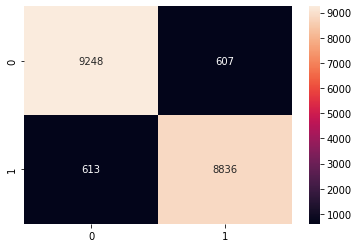

In [106]:
xgb_tfnum_cls = XGBClassifier(learning_rate = 0.1, max_depth = 11, tree_method = 'gpu_hist', gpu_id = 0, n_jobs = -1) # creating class object
xgb_tfnum_cls.fit(tf_num_train, y_train) # fitting to the training set

xgb_tfnum_ypred = xgb_tfnum_cls.predict(tf_num_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, xgb_tfnum_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [107]:
# Classification report of test set
print(classification_report(y_test, xgb_tfnum_ypred, digits=4))

              precision    recall  f1-score   support

           0     0.9378    0.9384    0.9381      9855
           1     0.9357    0.9351    0.9354      9449

    accuracy                         0.9368     19304
   macro avg     0.9368    0.9368    0.9368     19304
weighted avg     0.9368    0.9368    0.9368     19304



In [108]:
# Predicting on first test dataset
test1_tfxgb_ypred = xgb_tfnum_cls.predict(test1_tf_num)
print(classification_report(label_y1, test1_tfxgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6909    0.5938    0.6387      2846
           1     0.5776    0.6765    0.6232      2337

    accuracy                         0.6311      5183
   macro avg     0.6343    0.6352    0.6309      5183
weighted avg     0.6398    0.6311    0.6317      5183



In [109]:
# Predicting on 2nd test dataset
test2_tfpac_ypred = xgb_tfnum_cls.predict(test2_tf_num)
print(classification_report(label_y2, test2_tfpac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6773    0.9757    0.7995      3164
           1     0.9567    0.5361    0.6871      3171

    accuracy                         0.7556      6335
   macro avg     0.8170    0.7559    0.7433      6335
weighted avg     0.8171    0.7556    0.7433      6335



# Results of TFIDF values + Numeric Features

In [112]:
from sklearn.metrics import accuracy_score
train_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Passive Aggressive', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(y_test, log_tfnum_ypred), 
               accuracy_score(y_test, knn_tfnum_ypred),
               accuracy_score(y_test, svc_tfnum_ypred),
               accuracy_score(y_test, rand_tfnum_ypred),
               accuracy_score(y_test, pac_tfnum_ypred),
               accuracy_score(y_test, gb_tfnum_ypred),
              accuracy_score(y_test, xgb_tfnum_ypred)]
})

print("Prediction results of test set:")
train_result

Prediction results of test set:


,Model,Score
0,Logistic Regression,0.917116
1,KNN,0.787712
2,Linear SVM,0.888262
3,Random Forest,0.934366
4,Passive Aggressive,0.932812
5,Gradient Boosting,0.900332
6,XGBoost Classifier,0.936801


> From above report of model prediction on test set we can see XGBoost, Random Forest and Passive Aggressive have almost same performance on test set. However with number XGBoost has the highest accuracy followed by Random Forest and Passive Aggressive

In [113]:
test1_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Passive Aggressive', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(label_y1, test1_tflog_ypred),
               accuracy_score(label_y1, test1_tfknn_ypred),
               accuracy_score(label_y1, test1_tfsvc_ypred),
               accuracy_score(label_y1, test1_tfrand_ypred),
               accuracy_score(label_y1, test1_tfpac_ypred),
               accuracy_score(label_y1, test1_tfgb_ypred),
               accuracy_score(label_y1, test1_tfxgb_ypred)
              ]

})

print("Predictions on 1st Test Dataset: ")
test1_result

Predictions on 1st Test Dataset: 


,Model,Score
0,Logistic Regression,0.628208
1,KNN,0.627629
2,Linear SVM,0.628015
3,Random Forest,0.666602
4,Passive Aggressive,0.618947
5,Gradient Boosting,0.630137
6,XGBoost Classifier,0.631102


> From the above prediction results of various algoritms we can see Random Forest is performing better than any other algorithms on 1st Test Dataset

In [114]:
test2_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Passive Aggressive', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(label_y2, test2_tflog_ypred),
               accuracy_score(label_y2, test2_tfknn_ypred),
              accuracy_score(label_y2, test2_svc_ypred),
              accuracy_score(label_y2, test2_rand_ypred),
               accuracy_score(label_y2, test2_pac_ypred),
               accuracy_score(label_y2, test2_gb_ypred),
               accuracy_score(label_y2, test2_xgb_ypred)
               
              ]

})

print("Predictions on 2nd Test Dataset: ")
test2_result

Predictions on 2nd Test Dataset: 


,Model,Score
0,Logistic Regression,0.781847
1,KNN,0.708919
2,Linear SVM,0.758169
3,Random Forest,0.819890
4,Passive Aggressive,0.780900
5,Gradient Boosting,0.724230
6,XGBoost Classifier,0.748856


> From the above prediction results of various algorithms we can see Random Forest is performing better than any other algorithms on 2nd Test Dataset